# Instalacja pakietów

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, uniform, permutation_test
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import random

import math

In [2]:
plt.rcParams['text.usetex'] = True

# Funkcje pomocnicze

## Liczba rozmyta trójkątna (ang. Triangular Fuzzy Number, TFN)

In [3]:
class TriangularFuzzyNumber:
    # For the trinagular fuzzy number to be well-defined its parameters a,b,c need to be increasing
    def __init__(self, a, b, c):
        if a >= b or b >= c:
            raise ValueError("Niewłaściwe wartości parametrów.")
        self.a = a
        self.b = b
        self.c = c

    # Mebership function of a triangular fuzzy number
    def membership(self, x):
        if x < self.a or x > self.c:
            return 0.0
        elif x >= self.a and x <= self.b:
            return (x - self.a) / (self.b - self.a)
        elif x >= self.b and x <= self.c:
            return (self.c - x) / (self.c - self.b)

    # Function to plot the membership function of a triangular fuzzy number    
    def plot(self, label=None, color=None, alpha=None):

        if color is None:
            color = 'royalblue'
        if alpha is None:
            alpha = 1
        x_values = np.linspace(self.a - 1, self.c + 1, 1000)
        membership_values = [self.membership(x) for x in x_values]

        plt.plot(x_values, membership_values, label=label, color=color, alpha=alpha)

    # Credibility distribution of a triangular fuzzy number
    def calculate_cred_distr(self, x):
        result = np.zeros_like(x)
        result[(self.a <= x) & (x <= self.b)] = (x[(self.a <= x) & (x <= self.b)] - self.a) / (2 * (self.b - self.a))
        result[(self.b < x) & (x < self.c)] = (x[(self.b < x) & (x < self.c)] + self.c - 2 * self.b) / (2 * (self.c - self.b))
        result[x >= self.c] = 1
        return result

    
    # Function to plot the credibility distribution of a triangular fuzzy number    
    def plot_cred_distr(self, x_min=None, x_max=None, num_points=100, label=None, color=None, alpha=None):
        
        if color is None:
            color = 'royalblue'
        if alpha is None:
            alpha = 1
        if x_min is None:
            x_min = self.a
        if x_max is None:
            x_max = self.c
        x = np.linspace(x_min, x_max, num_points)
        y = self.calculate_cred_distr(x)

        plt.plot(x, y,label=label,color=color, alpha=alpha)

    # Inverse credibility distribution of a triangular fuzzy number
    def calculate_cred_distr_inv(self, y):
        result = np.zeros_like(y)
        result[y <= 0] = self.a
        result[(y > 0) & (y <= 0.5)] = self.a + 2 * (self.b - self.a) * y[(y > 0) & (y <= 0.5)]
        result[(y > 0.5) & (y < 1)] = self.b + 2 * (self.c - self.b) * (y[(y > 0.5) & (y < 1)] - 0.5)
        result[y >= 1] = self.c
        return result

    # Function to plot the inverse credibility distribution of a triangular fuzzy number    
    def plot_cred_distr_inv(self, y_min=0, y_max=1, num_points=100, label=None, color=None, alpha=None):

        if color is None:
            color = 'royalblue'
        if alpha is None:
            alpha = 1
        y = np.linspace(y_min, y_max, num_points)
        x = self.calculate_cred_distr_inv(y)

        plt.plot(y, x, label=label,color=color, alpha=alpha)

    # Function to convert the prameters of a triangular fuzzy number to array 
    def to_array(self):
        # Converts the triangular fuzzy number into a numpy array
        return np.array([self.a, self.b, self.c])

Definiowanie liczb typu TFN - można to robić dwojako. Ważna jest jednak kolejność argumentów!

In [4]:
tfn1 = TriangularFuzzyNumber(a = 1, b = 3, c = 6)
tfn2 = TriangularFuzzyNumber(2, 5, 8)

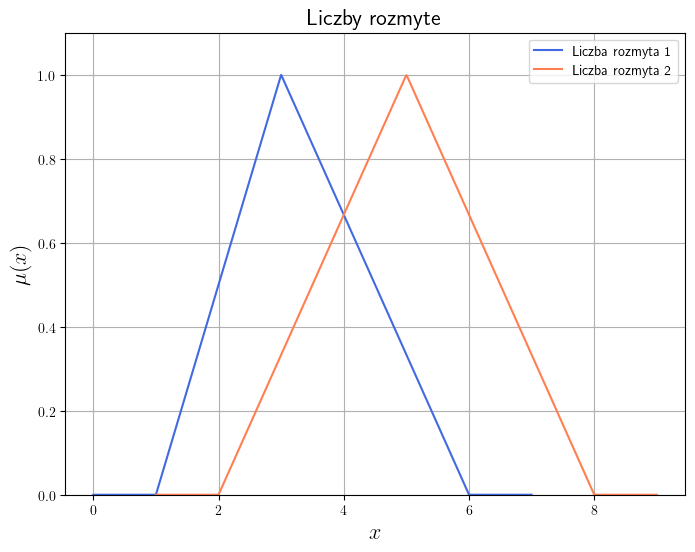

In [5]:
plt.figure(figsize=(8, 6))
tfn1.plot(label='Liczba rozmyta 1')
tfn2.plot(label='Liczba rozmyta 2', color='coral')

plt.title('Liczby rozmyte',fontsize=16)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$\mu(x)$',fontsize=16)
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.show()

Rozkład wiarygodności

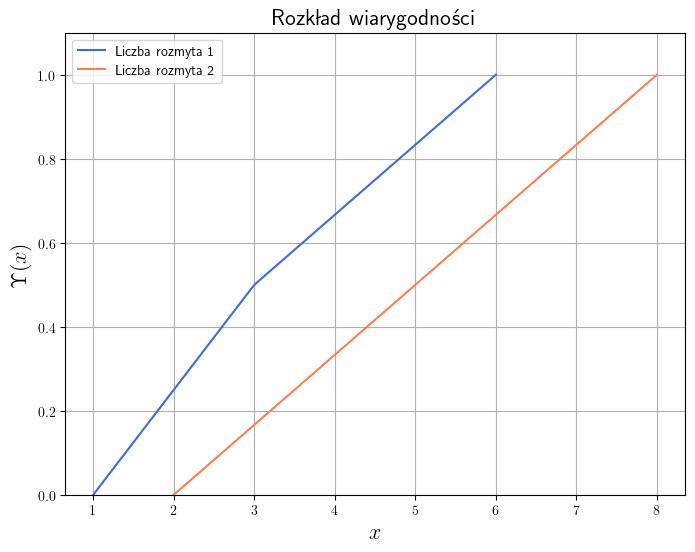

In [6]:
plt.figure(figsize=(8, 6))
tfn1.plot_cred_distr(label='Liczba rozmyta 1')
tfn2.plot_cred_distr(label='Liczba rozmyta 2', color='coral')

# Customize plot settings
plt.title('Rozkład wiarygodności',fontsize=16)
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r' $\displaystyle  \Upsilon(x)$',fontsize=16)
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.show()

Odwrotność rozkładu wiarygodności

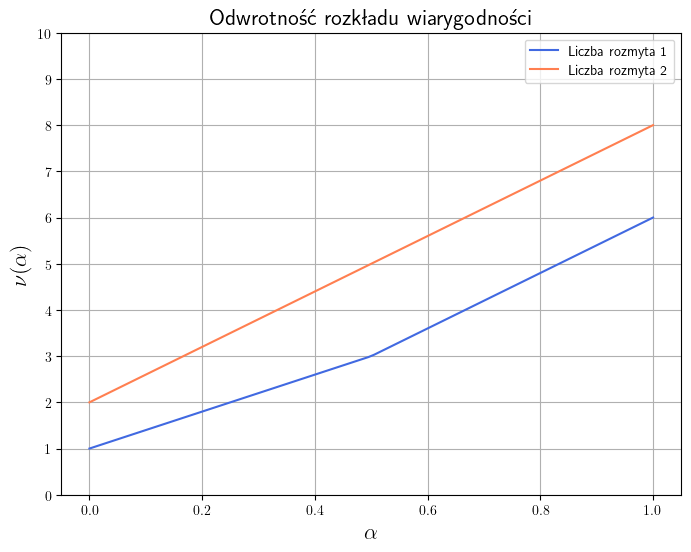

In [7]:
plt.figure(figsize=(8, 6))
tfn1.plot_cred_distr_inv(label='Liczba rozmyta 1')
tfn2.plot_cred_distr_inv(label='Liczba rozmyta 2', color='coral')

#plt.fill_between(x, tfn1.calculate_cred_distr_inv(x),  tfn2.calculate_cred_distr_inv(x), color = 'aliceblue')

plt.legend()
plt.grid(True)
plt.xlabel(r'$\displaystyle \alpha $',fontsize=16)
plt.ylabel(r' $\displaystyle  \nu(\alpha)$',fontsize=16)
plt.title("Odwrotność rozkładu wiarygodności",fontsize=16)
plt.ylim(0, 10)
plt.yticks(range(0, 11))
plt.show()

Funkcja do generowania liczb typu TFN. Jądro $b$ is pochodzi z rozkładu normalnego zadanego przez parametry $\mu$ i $\sigma.$ Odległości punktów $a$ i $c$ od $b$ mają rozład jednostajny na odpowiednio $[0, \delta_1]$ i $[0,\delta_2].$ 

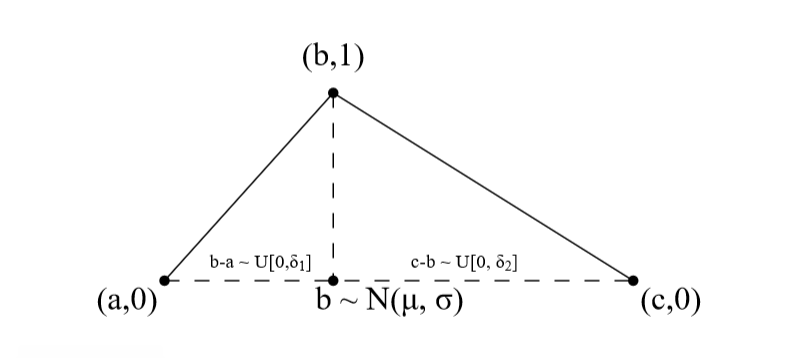|

In [8]:
def generate_TFN(mu, sigma, delta_1, delta_2, sample_size=1000):
    tfns = []
    for _ in range(sample_size):
        
        # Generate b from a normal distribution
        b = norm.rvs(loc=mu, scale=sigma)

        # Generate xi_1 from a uniform distribution
        xi_1 = uniform.rvs(loc=0.000001, scale=delta_1)

        # Generate xi_2 from a uniform distribution
        xi_2 = uniform.rvs(loc=0.000001, scale=delta_2)

        # Calculate a and c
        a = b - xi_1
        c = b + xi_2
        
        tfns.append(TriangularFuzzyNumber(a, b, c))
    
    return tfns

Średnia z próbki liczb typu TFN

In [9]:
def mean_TFN(tfns):

    mean_a = np.mean([tfn.a for tfn in tfns])
    mean_b = np.mean([tfn.b for tfn in tfns])
    mean_c = np.mean([tfn.c for tfn in tfns])

    return TriangularFuzzyNumber(mean_a, mean_b, mean_c)

## Dystanse

Odległość $L^2$ pomiędzy wykresami odwrotnych rozkładów wiarygodności dla TFN

In [10]:
def TFN_l2_distance(tfn1: TriangularFuzzyNumber, tfn2: TriangularFuzzyNumber):
    a1 = tfn1.a
    b1 = tfn1.b
    c1 = tfn1.c
    a2 = tfn2.a
    b2 = tfn2.b
    c2 = tfn2.c
    distance = ((b1-a1-b2+a2)**2)/6 + (b1-a1-b2+a2)*(a1-a2)/2 + ((a1-a2)**2)/2 + (7/6)*(c1-b1-c2+b2)**2 + (3/2)*(c1-b1-c2+b2)*(2*(b1-b2)-(c1-c2)) + (1/2)*(2*(b1-b2)-(c1-c2))**2
    return distance

Odległość energetyczna dla liczb rozmytych trójkątnych. Domyślna wartość wagi $\theta$ to $1.$

In [11]:
def TFN_energy_distance(tfn1: TriangularFuzzyNumber, tfn2: TriangularFuzzyNumber, theta: float = 1):
    
    a1 = tfn1.a
    b1 = tfn1.b
    c1 = tfn1.c
    a2 = tfn2.a
    b2 = tfn2.b
    c2 = tfn2.c

    mid_0_1 = (a1+c1)/2 # midpoint of the support
    mid_1_1= b1 # midpoint of the core
    spr_0_1 = c1-a1 # spread of the support
    spr_1_1 = 0 # spread of the core

    mid_0_2 = (a2+c2)/2
    mid_1_2= b2
    spr_0_2 = c2-a2
    spr_1_2 = 0

    distance = (((mid_0_1-mid_0_2)**2)/3 + ((mid_1_1-mid_1_2)**2)/3 + (mid_0_1-mid_0_2)*(mid_1_1-mid_1_2)/3 + theta*((spr_0_1-spr_0_2)**2
    )/3 + theta*((spr_1_1-spr_1_2)**2)/3 + theta*((spr_0_1-spr_0_2)*(spr_1_1-spr_1_2))/3)**0.5

    return distance

## Porównywanie

In [12]:
def TFN_credibility_index(tfn1: TriangularFuzzyNumber, tfn2: TriangularFuzzyNumber):
        
    a1 = tfn1.a
    b1 = tfn1.b
    c1 = tfn1.c
    a2 = tfn2.a
    b2 = tfn2.b
    c2 = tfn2.c

    if b1 < b2 and c1 <= a2:
        return 0.0
    elif b1 < b2 and c1 > a2:
        h = (c1*b2 - a2*b1)/(b2-a2-b1+c1)
        return (h-c1)/(2* (b1-c1))
    elif b1 == b2:
        return 0.5
    elif b1 > b2 and a1 < c2:
        h = (a1*b2 - c2*b1)/(b2-c2-b1+a1)
        return 1-(h-a1)/(2* (b1-a1))
    elif b1 > b2 and a1 >= c2:
        return 1

# Testowanie hipotez

## Generowanie próbek

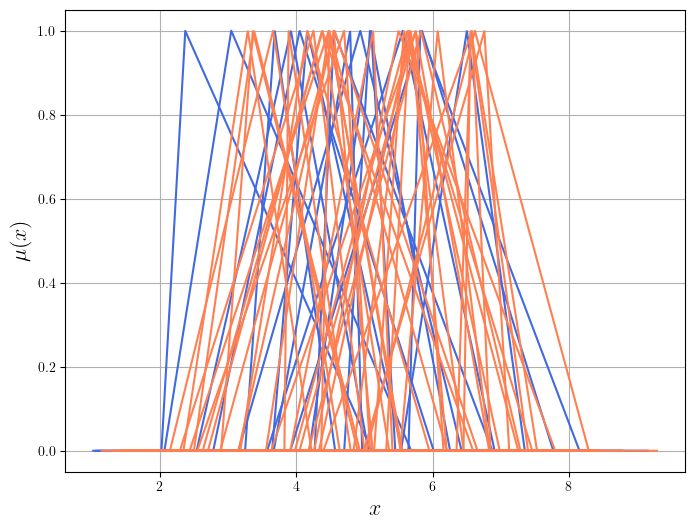

In [14]:
mu = 5
sigma = 1
delta_1 = 2
delta_2 = 3
sample_size = 15
tfns_1 = generate_TFN(mu, sigma, delta_1, delta_2, sample_size)
tfns_2 = generate_TFN(mu, sigma+0.1, delta_1+0.3, delta_2-0.7, sample_size+16)

# Plot all TFNs
plt.figure(figsize=(8, 6))
for tfn in tfns_1:
    tfn.plot()  
for tfn in tfns_2:
    tfn.plot(color='coral') 
#plt.title('Dwie próbki liczb rozmytych',fontsize=16)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$\mu(x)$',fontsize=16)
plt.grid(True)
plt.show()

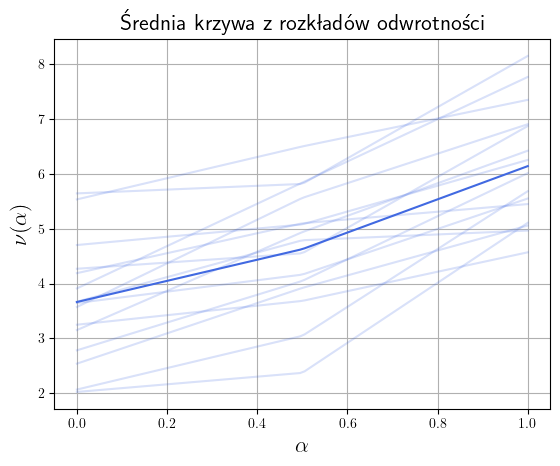

In [15]:
mean_tfn1 = mean_TFN(tfns_1)

for tfn in tfns_1:
    tfn.plot_cred_distr_inv(alpha=0.2)
mean_tfn1.plot_cred_distr_inv()

plt.xlabel(r'$ \alpha $',fontsize=16)
plt.ylabel(r' $  \nu(\alpha)$',fontsize=16)
plt.title('Średnia krzywa z rozkładów odwrotności',fontsize=16)
plt.grid(True)
plt.show()

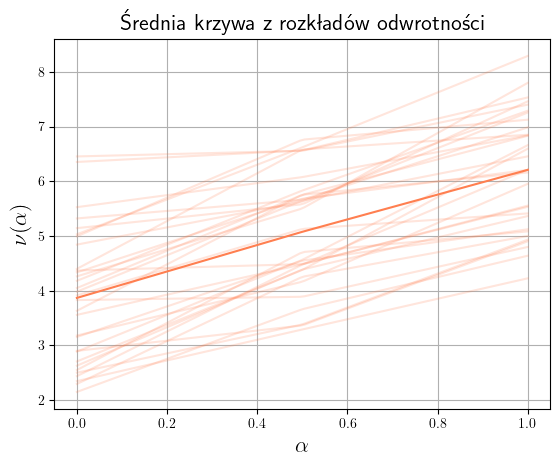

In [16]:
mean_tfn2 = mean_TFN(tfns_2)

for tfn in tfns_2:
    tfn.plot_cred_distr_inv(alpha=0.2, color='coral')
mean_tfn2.plot_cred_distr_inv(color='coral')

plt.xlabel(r'$\alpha $',fontsize=16)
plt.ylabel(r' $ \nu(\alpha)$',fontsize=16)
plt.title('Średnia krzywa z rozkładów odwrotności',fontsize=16)
plt.grid(True)
plt.show()

In [17]:
l2_distance = TFN_l2_distance(mean_tfn1, mean_tfn2)

In [20]:
x = np.linspace(0,1,10000)

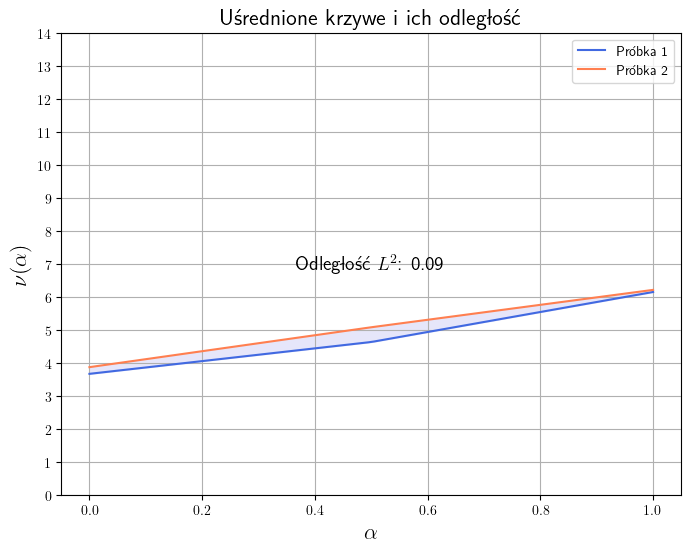

In [21]:
plt.figure(figsize=(8, 6))
mean_tfn1.plot_cred_distr_inv(label='Próbka 1')
mean_tfn2.plot_cred_distr_inv(label='Próbka 2', color='coral')

plt.fill_between(x, mean_tfn1.calculate_cred_distr_inv(x), mean_tfn2.calculate_cred_distr_inv(x), color = 'lavender')

# Customize plot settings
plt.legend()
plt.grid(True)
plt.xlabel(r'$ \alpha $',fontsize=16)
plt.ylabel(r' $ \nu(\alpha)$',fontsize=16)
plt.title('Uśrednione krzywe i ich odległość',fontsize=16)
plt.ylim(0, 14)
plt.yticks(range(0, 15))
plt.text(0.5, 7, f'Odległość $L^2$: {l2_distance:.2f}', fontsize = 14, ha='center', va='center')
plt.show()

## Statystyki testowe

Statystyka dla liczb trójkątnych bazująca na odległości $L^2$ zaproponowana w mojej pracy

In [22]:
def TFN_statistic(sample1, sample2):

    # L2 distance between the means of each sample is calculated 
    statistic = TFN_l2_distance(mean_TFN(sample1), mean_TFN(sample2))
    
    return statistic

Statystyka testowa dla liczb trójkątnych bazująca na odległości energetycznej zaproponowanej w pracy *Permutation k-sample Goodness-of-Fit Test for Fuzzy Data*

In [23]:
def TFN_statistic_pgrzeg(sample1, sample2):
        
    # Sizes of the samples
    n = len(sample1)
    m = len(sample2)

    # Mean of the pooled sample
    mean_combined_samples = mean_TFN(np.concatenate([sample1, sample2]))

    # Test statistic is the sum of weighted squares of the earlier defined distance proposed by przgeg, same one as used in 
    # previous statistic.
    # For simplified implementation, the mean of the pooled samples is always evaluated, though it is constant despite pooling.
    # This causes a slight increase in the needed computations.
    statistic =n*TFN_energy_distance(mean_TFN(sample1), mean_combined_samples)**2 + m*TFN_energy_distance(
    mean_TFN(sample2), mean_combined_samples)**2
    
    return statistic

Statystyka testowa dla liczb trójkątnych bazująca na odległości energetycznej Szekelego i Rizzo

In [24]:
def TFN_statistic_szekely(sample1, sample2):
    n = len(sample1)
    m = len(sample2)


    XY_term =  0 
    XX_term =  0 
    YY_term =  0 
    
    for idx1, tfn_x_1 in enumerate(sample1):
        for tfn_y_2 in sample2:

            energy_distance = TFN_energy_distance(tfn_x_1, tfn_y_2)
            XY_term  += energy_distance

        for idx2, tfn_x_2 in enumerate(sample1):

            energy_distance = TFN_energy_distance(tfn_x_1, tfn_x_2)
            
            if idx2 < idx1:
                XX_term  += 2*energy_distance
            elif idx1 == idx2:
                XX_term  += energy_distance
            else:
                break
            

    for idx1, tfn_y_1 in enumerate(sample2):
        for idx2, tfn_y_2 in enumerate(sample2):

            energy_distance = TFN_energy_distance(tfn_y_1, tfn_y_2)
            
            if idx2 < idx1:
                YY_term  += 2*energy_distance
            elif idx1 == idx2:
                YY_term  += energy_distance
            else:
                break

    statistic = (n*m)/(n+m)*(2*XY_term/(n*m)-XX_term/n**2-YY_term/m**2)

    return statistic
    

Uogólniona statystyka testowa Manna-Whitneya (Milena)

In [25]:
def TFN_statistic_milena(sample1, sample2):
    n = len(sample1)
    m = len(sample2)

    statistic =  0 
    
    for tfn_x_1 in sample1:
        for tfn_y_2 in sample2:

            credibility_index = TFN_credibility_index(tfn_x_1, tfn_y_2)
            statistic  += credibility_index

    return statistic

Statystyka testowa dla liczb trójkątnych bazująca na odległości zaproponowanej w pracy *k-Nearest Neighbors Test for Fuzzy Data*

In [26]:
def TFN_statistic_knn(sample1, sample2, k=5):

    # Pooled sample
    combined_samples = np.concatenate([sample1, sample2])
    
    # Sizes of the samples
    sample1_size = len(sample1)
    sample2_size = len(sample2)

    # Labels: 0 stands for the first sample, 1 for the second sample
    labels = np.array([0] * sample1_size + [1] * sample2_size)
    
    # For calculation purposes the tfns need to be converted to arrays (tfn objects are problematic for the future use)
    combined_samples_array = np.array([s.to_array() for s in combined_samples])
    
    # Nearest neighbors algorithm to find the closest k neighbors in terms of our defined metric
    # Lambda function had to be used since user-implmented metric is not working properly
    nbrs = NearestNeighbors(n_neighbors=k, metric=lambda x, y: TFN_energy_distance(TriangularFuzzyNumber(*x), TriangularFuzzyNumber(*y)))
    nbrs.fit(combined_samples_array)
    
    # The indexes of the k neighbors of each element in the sample
    indices = nbrs.kneighbors(combined_samples_array, return_distance=False)
    
    # Loop to count neighbors that belong to the sample
    same_sample_counts = 0
    for idx, neighbors in enumerate(indices):
        current_label = labels[idx]
        same_sample_count = np.sum(labels[neighbors] == current_label)
        same_sample_counts += same_sample_count
    
    test_statistic = same_sample_counts / (k * (sample1_size + sample2_size))
    
    return test_statistic

Statystyka punktowa A. Kozak i P. Grzegorzewski

In [27]:
def TFN_statistic_kozak(sample1, sample2):

    sample1_size = len(sample1)
    sample2_size = len(sample2)

    alphas = np.linspace(0,1,1000)

    inv_distr_mean_1 = np.mean([tfn1.calculate_cred_distr_inv(alphas) for tfn1 in sample1],axis= 0)
    inv_distr_mean_2 = np.mean([tfn2.calculate_cred_distr_inv(alphas) for tfn2 in sample2],axis= 0)

    st_dev_1 = np.std([tfn1.calculate_cred_distr_inv(alphas) for tfn1 in sample1],axis=0,ddof= 1)
    st_dev_2 = np.std([tfn2.calculate_cred_distr_inv(alphas) for tfn2 in sample2],axis=0,ddof= 1)

    t_alphas = np.abs( inv_distr_mean_1-inv_distr_mean_2)/(1/sample1_size*st_dev_1 + 1/sample2_size*st_dev_2)**0.5

    statistic = np.max(t_alphas)
    
    return statistic

## Test

In [28]:
def permutation_test(sample1, sample2, statistic, num_permutations=1000, plot_histogram=False):
    
    # Combine the samples
    combined_samples = np.concatenate([sample1, sample2])

    # Observed test statistic
    observed_statistic =statistic(sample1, sample2)

    # Initialize array to store permuted test statistics
    permuted_statistics = np.zeros(num_permutations)

    for i in range(num_permutations):
        # Permute the combined samples
        permuted_samples = np.random.permutation(combined_samples)

        # Compute the test statistic for permuted samples
        permuted_sample1 = permuted_samples[:len(sample1)]
        permuted_sample2 = permuted_samples[len(sample1):]
        permuted_statistics[i] = statistic(permuted_sample1, permuted_sample2)
        # permuted_statistics[i] = np.abs(permuted_statistic - observed_statistic)

    # Compute the p-value
    p_value = np.mean(permuted_statistics >= observed_statistic)

    if plot_histogram:
        plt.hist(permuted_statistics, bins=50, color='skyblue', edgecolor='black')
        plt.xlabel('Wartości statystyk')
        plt.ylabel('Czestotliwość')
        plt.title('Histogram statystyk testowych')
        plt.axvline(np.abs(observed_statistic), color='red', linestyle='--', label='Wyjściowa wartość statystyki')
        plt.legend()
        plt.show()

    return p_value

### Nowa implemetacja testu dla k najbliższych sąsiadów

In [29]:
def count_matching_labels(neighbors, labels):

    same_sample_counts = 0
    for idx, neighbors in enumerate(neighbors):
        current_label = labels[idx]
        same_sample_count = np.sum(labels[neighbors] == current_label)
        same_sample_counts += same_sample_count
    
    return same_sample_counts

In [30]:
def permutation_test_knn(sample1, sample2, k=5, num_permutations=1000, plot_histogram=False):
    
    # Pooled sample
    combined_samples = np.concatenate([sample1, sample2])
    
    # Sizes of the samples
    sample1_size = len(sample1)
    sample2_size = len(sample2)

    # Labels: 0 stands for the first sample, 1 for the second sample
    labels = np.array([0] * sample1_size + [1] * sample2_size)
    
    # For calculation purposes the tfns need to be converted to arrays (tfn objects are problematic for the future use)
    combined_samples_array = np.array([s.to_array() for s in combined_samples])
    
    # Nearest neighbors algorithm to find the closest k neighbors in terms of our defined metric
    # Lambda function had to be used since user-implmented metric is not working properly
    nbrs = NearestNeighbors(n_neighbors=k, metric=lambda x, y: TFN_energy_distance(TriangularFuzzyNumber(*x), TriangularFuzzyNumber(*y)))
    nbrs.fit(combined_samples_array)
    
    # The indexes of the k neighbors of each element in the sample
    neighbors = nbrs.kneighbors(combined_samples_array, return_distance=False)

    observed_statistic =  count_matching_labels(neighbors, labels) / (k * (sample1_size + sample2_size))

    # Initialize array to store permuted test statistics
    permuted_statistics = np.zeros(num_permutations)

    for i in range(num_permutations):
        
        #new_labels = random.sample(labels, len(labels))
        np.random.shuffle(labels)
        permuted_statistics[i] = count_matching_labels(neighbors, labels) / (k * (sample1_size + sample2_size))

    # Compute the p-value
    p_value = np.mean(permuted_statistics >= observed_statistic)

    if plot_histogram:
        plt.hist(permuted_statistics, bins=50, color='skyblue', edgecolor='black')
        plt.xlabel('Wartości statystyk')
        plt.ylabel('Czestotliwość')
        plt.title('Histogram statystyk testowych')
        plt.axvline(np.abs(observed_statistic), color='red', linestyle='--', label='Wyjściowa wartość statystyki')
        plt.legend()
        plt.show()

    return p_value

###  Działanie testów

In [31]:
u = 3
sigma = 0.4
delta_1 = 0.5
delta_2 = 0.6
sample_size = 25
tfns_1 = generate_TFN(mu+0.4, sigma, delta_1, delta_2, sample_size)
tfns_2 = generate_TFN(mu, sigma+0.1, delta_1+0.1, delta_2-0.1, sample_size+16)

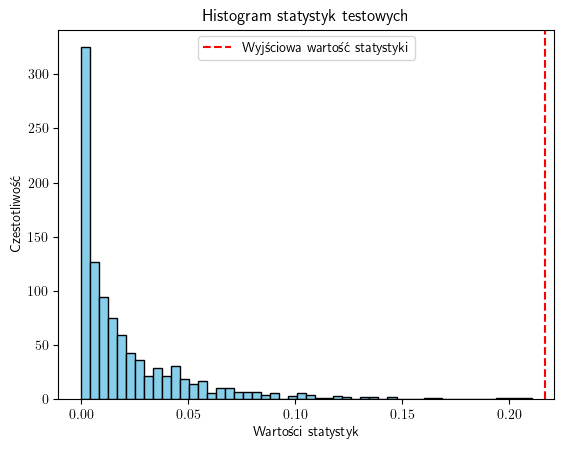

0.0

In [32]:
permutation_test(tfns_1, tfns_2, TFN_statistic, plot_histogram=True)

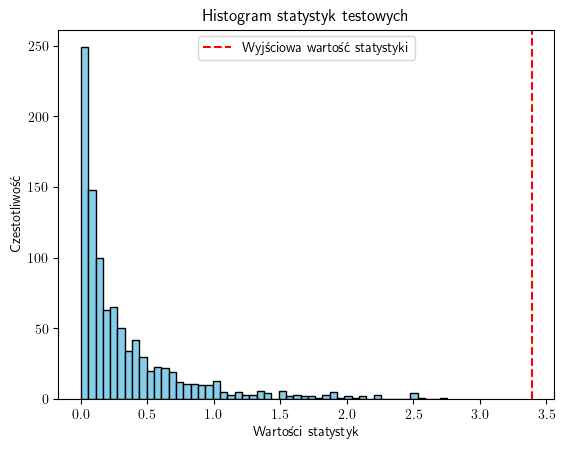

0.0

In [33]:
permutation_test(tfns_1, tfns_2, TFN_statistic_pgrzeg, plot_histogram=True)

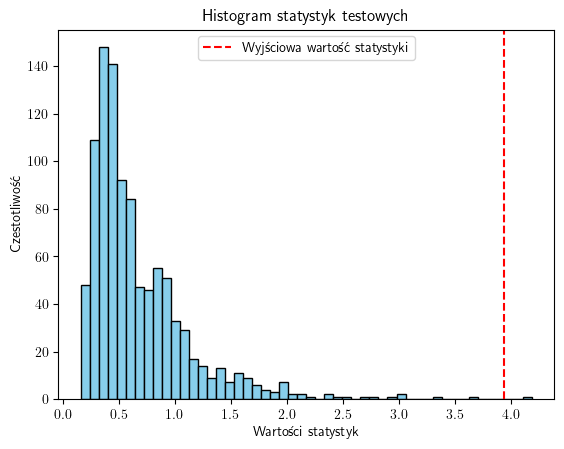

0.001

In [34]:
permutation_test(tfns_1, tfns_2, TFN_statistic_szekely, plot_histogram=True)

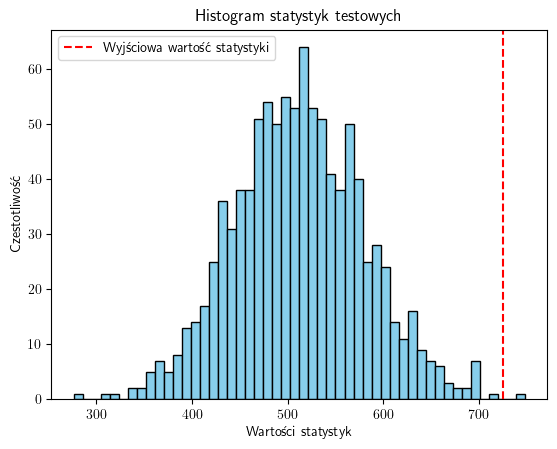

0.001

In [35]:
permutation_test(tfns_1, tfns_2, TFN_statistic_milena, plot_histogram=True)

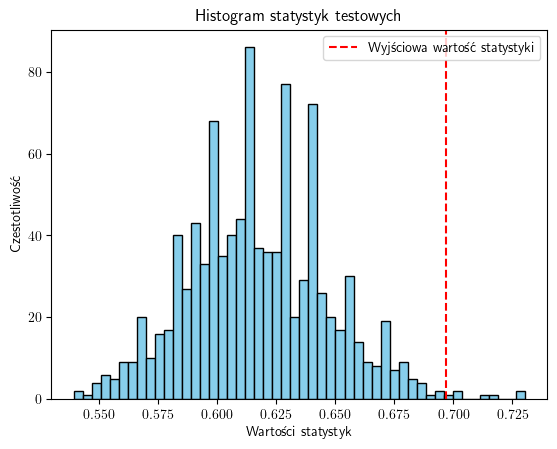

0.007

In [36]:
permutation_test_knn(tfns_1, tfns_2, plot_histogram=True)

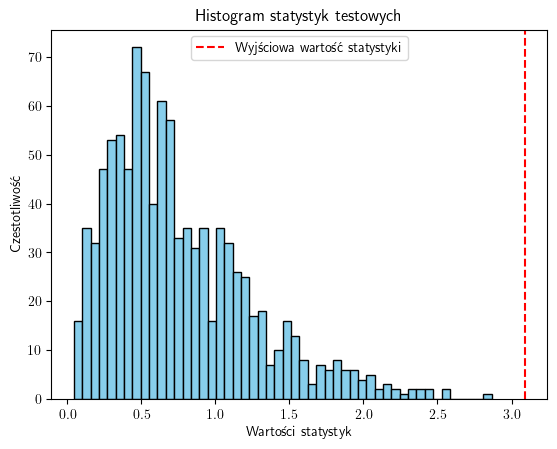

0.0

In [37]:
permutation_test(tfns_1, tfns_2, TFN_statistic_kozak, plot_histogram=True)

## $H_0$ prawdziwa - rozmiar testu

In [38]:
def empirical_size(sample_pairs, sample_parameters, test_statistic, num_tests=1000):
    results = []
    for (sample_size1, sample_size2) in sample_pairs:
        mu1, sigma1, delta_1_1, delta_2_1 = sample_parameters[0]
        mu2, sigma2, delta_1_2, delta_2_2 = sample_parameters[1]
        for _ in range(num_tests):
            # Generate samples
            sample1 = generate_TFN(mu1, sigma1, delta_1_1, delta_2_1, sample_size1)
            sample2 = generate_TFN(mu2, sigma2, delta_1_2, delta_2_2, sample_size2)
            
            # Perform permutation test
            p_value = permutation_test(sample1, sample2, test_statistic, num_permutations=1000)
            
            # Check if p-value is less than or equal to 0.05
            if p_value <= 0.05:
                results.append({
                    'sample_size1': sample_size1,
                    'sample_size2': sample_size2,
                    'empirical_size': 1
                })
            else:
                results.append({
                    'sample_size1': sample_size1,
                    'sample_size2': sample_size2,
                    'empirical_size': 0
                })
    
    df = pd.DataFrame(results)
    summary_table = df.groupby(['sample_size1', 'sample_size2']).agg(empirical_size=('empirical_size', 'mean')).reset_index()
    return summary_table

Do policzenia wyłącznie komórka niżej!

In [ ]:
sample_pairs = [(10,10), (10, 15), (15, 15), (20, 20), (20, 15), (25, 20), (25,25)]  # Define pairs of sample_size1 and sample_size2
sample_parameters = [
    [5, 0.5, 0.5, 0.6],  # Parameters for sample 1
    [5, 0.5, 0.4, 0.5]   # Parameters for sample 2
]

print(empirical_size(sample_pairs, sample_parameters, TFN_statistic))

### Wyniki empiryczne

Poniżej nie liczyć!

In [ ]:
sample_pairs = [(10,10), (10, 15), (15, 15), (20, 20), (20, 15), (25, 20), (25,25)]  # Define pairs of sample_size1 and sample_size2
sample_parameters = [
    [5, 1, 2, 3],  # Parameters for sample 1
    [5, 1.5, 3.3, 2.3]   # Parameters for sample 2
]

print(empirical_size(sample_pairs, sample_parameters, TFN_statistic, num_tests=100))

   num_samples1  num_samples2  empirical_size
0            10            10            0.06
1            10            15            0.06
2            15            15            0.11
3            20            15            0.08
4            20            20            0.13
5            25            20            0.15
6            25            25            0.12


In [ ]:
print(empirical_size(sample_pairs, sample_parameters, num_tests=1000))

In [ ]:
sample_pairs = [(10,10), (10, 15), (15, 15), (20, 20), (20, 15), (25, 20), (25,25)]  # Define pairs of sample_size1 and sample_size2
sample_parameters = [
    [5, 0.5, 2, 3],  # Parameters for sample 1
    [5, 0.75, 3.3, 2.3]   # Parameters for sample 2
]

print(empirical_size(sample_pairs, sample_parameters, num_tests=100))

   num_samples1  num_samples2  empirical_size
0            10            10            0.15
1            10            15            0.14
2            15            15            0.24
3            20            15            0.20
4            20            20            0.30
5            25            20            0.31
6            25            25            0.36


In [ ]:
print(empirical_size(sample_pairs, sample_parameters, num_tests=1000))

In [ ]:
sample_pairs = [(10,10), (10, 15), (15, 15), (20, 20), (20, 15), (25, 20), (25,25)]  # Define pairs of sample_size1 and sample_size2
sample_parameters = [
    [5, 1, 2, 3],  # Parameters for sample 1
    [5, 1, 2, 3]   # Parameters for sample 2
]

print(empirical_size(sample_pairs, sample_parameters, num_tests=100))

   num_samples1  num_samples2  empirical_size
0            10            10            0.03
1            10            15            0.05
2            15            15            0.06
3            20            15            0.12
4            20            20            0.01
5            25            20            0.06
6            25            25            0.03


In [ ]:
print(empirical_size(sample_pairs, sample_parameters, num_tests=1000))

In [ ]:
sample_pairs = [(10,10), (10, 15), (15, 15), (20, 20), (20, 15), (25, 20), (25,25)]  # Define pairs of sample_size1 and sample_size2
sample_parameters = [
    [5, 1, 2.3, 3],  # Parameters for sample 1
    [5, 1, 1.7, 3]   # Parameters for sample 2
]

print(empirical_size(sample_pairs, sample_parameters, num_tests=100))

   num_samples1  num_samples2  empirical_size
0            10            10            0.07
1            10            15            0.06
2            15            15            0.05
3            20            15            0.07
4            20            20            0.03
5            25            20            0.09
6            25            25            0.04


In [ ]:
print(empirical_size(sample_pairs, sample_parameters, num_tests=1000))

In [ ]:
sample_pairs = [(10,10), (10, 15), (15, 15), (20, 20), (20, 15), (25, 20), (25,25)]  # Define pairs of sample_size1 and sample_size2
sample_parameters = [
    [5, 1, 2.3, 2.5],  # Parameters for sample 1
    [5, 1, 1.7, 3.5]   # Parameters for sample 2
]

print(empirical_size(sample_pairs, sample_parameters, num_tests=100))

   num_samples1  num_samples2  empirical_size
0            10            10            0.11
1            10            15            0.06
2            15            15            0.07
3            20            15            0.12
4            20            20            0.08
5            25            20            0.05
6            25            25            0.16


In [ ]:
print(empirical_size(sample_pairs, sample_parameters, num_tests=1000))

In [ ]:
sample_pairs = [(10,10), (10, 15), (15, 15), (20, 20), (20, 15), (25, 20), (25,25)]  # Define pairs of sample_size1 and sample_size2
sample_parameters = [
    [5, 1, 2.3, 2.2],  # Parameters for sample 1
    [5, 1, 1.7, 1.8]   # Parameters for sample 2
]

print(empirical_size(sample_pairs, sample_parameters, num_tests=100))

   num_samples1  num_samples2  empirical_size
0            10            10            0.03
1            10            15            0.06
2            15            15            0.06
3            20            15            0.09
4            20            20            0.07
5            25            20            0.03
6            25            25            0.11


In [ ]:
print(empirical_size(sample_pairs, sample_parameters, num_tests=1000))

In [ ]:
sample_pairs = [(10,10), (10, 15), (15, 15), (20, 20), (20, 15), (25, 20), (25,25)]  # Define pairs of sample_size1 and sample_size2
sample_parameters = [
    [5, 1.1, 2.3, 2.2],  # Parameters for sample 1
    [5, 0.9, 1.7, 1.8]   # Parameters for sample 2
]

print(empirical_size(sample_pairs, sample_parameters, num_tests=100))

   num_samples1  num_samples2  empirical_size
0            10            10            0.06
1            10            15            0.06
2            15            15            0.04
3            20            15            0.07
4            20            20            0.04
5            25            20            0.03
6            25            25            0.05


In [ ]:
print(empirical_size(sample_pairs, sample_parameters, num_tests=1000))

In [ ]:
sample_pairs = [(10,10), (10, 15), (15, 15), (20, 20), (20, 15), (25, 20), (25,25)]  # Define pairs of sample_size1 and sample_size2
sample_parameters = [
    [0, 1.1, 2.3, 2.2],  # Parameters for sample 1
    [0, 0.9, 1.7, 1.8]   # Parameters for sample 2
]

print(empirical_size(sample_pairs, sample_parameters, num_tests=100))

   num_samples1  num_samples2  empirical_size
0            10            10            0.04
1            10            15            0.07
2            15            15            0.03
3            20            15            0.07
4            20            20            0.04
5            25            20            0.10
6            25            25            0.07


In [ ]:
print(empirical_size(sample_pairs, sample_parameters, num_tests=1000))

In [ ]:
sample_pairs = [(5,10),(10,10), (10, 15), (15, 15), (20, 20), (20, 15), (25, 20), (25,25), (20,30),(40,50), (50,75)]  # Define pairs of sample_size1 and sample_size2
sample_parameters = [
    [0, 1.05, 2.2, 2.15],  # Parameters for sample 1
    [0, 0.95, 1.8, 1.85]   # Parameters for sample 2
]

print(empirical_size(sample_pairs, sample_parameters, num_tests=100))

    num_samples1  num_samples2  empirical_size
0              5            10            0.05
1             10            10            0.05
2             10            15            0.02
3             15            15            0.03
4             20            15            0.03
5             20            20            0.07
6             20            30            0.05
7             25            20            0.09
8             25            25            0.09
9             40            50            0.08
10            50            75            0.09


In [ ]:
print(empirical_size(sample_pairs, sample_parameters, num_tests=1000))

In [ ]:
sample_pairs = [(5,10),(10,10), (10, 15), (15, 15), (20, 20), (20, 15), (25, 20), (25,25), (20,30),(40,50), (50,75)]  # Define pairs of sample_size1 and sample_size2
sample_parameters = [
    [0, 1.05, 1.2, 1.15],  # Parameters for sample 1
    [0, 0.95, 0.8, 0.85]   # Parameters for sample 2
]

print(empirical_size(sample_pairs, sample_parameters, num_tests=100))

    num_samples1  num_samples2  empirical_size
0              5            10            0.08
1             10            10            0.04
2             10            15            0.07
3             15            15            0.02
4             20            15            0.06
5             20            20            0.06
6             20            30            0.09
7             25            20            0.03
8             25            25            0.02
9             40            50            0.05
10            50            75            0.06


In [ ]:
print(empirical_size(sample_pairs, sample_parameters, num_tests=1000))

In [ ]:
sample_pairs = [(5,10),(10,10), (10, 15), (15, 15), (20, 20), (20, 15), (25, 20), (25,25), (20,30),(40,50), (50,75)]  # Define pairs of sample_size1 and sample_size2
sample_parameters = [
    [0, 2.1, 2.4, 2.3],  # Parameters for sample 1 
    [0, 1.9, 1.6, 1.7]   # Parameters for sample 2
]

print(empirical_size(sample_pairs, sample_parameters, num_tests=100))

    num_samples1  num_samples2  empirical_size
0              5            10            0.05
1             10            10            0.07
2             10            15            0.06
3             15            15            0.09
4             20            15            0.05
5             20            20            0.06
6             20            30            0.07
7             25            20            0.07
8             25            25            0.05
9             40            50            0.02
10            50            75            0.06


In [ ]:
print(empirical_size(sample_pairs, sample_parameters, num_tests=1000))

## $H_1$ prawdziwa - moc testu

Służy do liczenia mocy zadanego testu

In [39]:
def calculate_power(mu, sigma, delta_1, delta_2, differences, test_statistic, 
                    sample_size=100,  num_tests=1000, num_permutations=1000, return_power = False):
    powers = []
    for difference in differences:
        num_rejections = 0
        for _ in range(num_tests):
            # Generate samples
            sample1 = generate_TFN(mu, sigma, delta_1, delta_2, sample_size)
            sample2 = generate_TFN(mu + difference, sigma, delta_1, delta_2, sample_size)  # Increase mean for sample 2
            
            # Perform permutation test
            p_value = permutation_test(sample1, sample2, test_statistic, num_permutations=num_permutations)
            
            # Check if p-value is less than or equal to 0.05
            if p_value <= 0.05:
                num_rejections += 1
        
        power = num_rejections / num_tests
        powers.append(power)
    
    # Plot power vs difference between means
    plt.plot(differences, powers)
    plt.xlabel("$\mu_2-\mu_1$", fontsize=16)
    plt.ylabel("Moc", fontsize=16)
    plt.title("Krzywa mocy", fontsize=16)
    plt.grid(True)
    #plt.show()

    if return_power:
        results = []
        
        results.append({
            'parameters': [mu, sigma, delta_1, delta_2],
            'differences': differences,
            'empirical_power': powers
                })
            
        df = pd.DataFrame(results)
        return df

### Wyniki empiryczne

In [40]:
differences = np.linspace(0, 2, 10)  

calculate_power(mu=2, sigma=1, delta_1=1.5, delta_2=2.5,differences=differences, test_statistic=TFN_statistic,)


KeyboardInterrupt: 

In [ ]:
differences = np.linspace(0, 2, 10)  

calculate_power(mu=5, sigma=1, delta_1=1.5, delta_2=2.5,differences=differences, test_statistic=TFN_statistic,)


In [ ]:
differences = np.linspace(0, 2, 10)  

calculate_power(mu=5, sigma=3, delta_1=2.5, delta_2=3.5, sample_size=10,differences=differences, test_statistic=TFN_statistic,)


In [ ]:
differences = np.linspace(0, 3, 10)  

calculate_power(mu=5, sigma=3, delta_1=2.5, delta_2=3.5, sample_size=10,differences=differences, test_statistic=TFN_statistic,)


# Porównanie testów

Porównanie mocy testów

In [42]:
def calculate_multiple_powers(mu, sigma, delta_1, delta_2, differences, sample_size=100, num_tests=1000, num_permutations=1000, return_power=False):
    powers_TFN = []
    powers_Pgrzeg = []
    powers_KNN = []
    powers_szekely = []
    powers_milena = []
    powers_kozak = []
    
    for difference in differences:
        # Initialize counters for rejections
        rejections_TFN = 0
        rejections_Pgrzeg = 0
        rejections_KNN = 0
        rejections_szekely = 0
        rejections_milena = 0
        rejections_kozak = 0
        
        for _ in range(num_tests):
            # Generate samples
            sample1 = generate_TFN(mu, sigma, delta_1, delta_2, sample_size)
            sample2 = generate_TFN(mu + difference, sigma, delta_1, delta_2, sample_size)  # Increase mean for sample 2

            # Calculate p-values for different tests
            p_value = permutation_test(sample1, sample2, TFN_statistic, num_permutations=num_permutations)
            p_value2 = permutation_test(sample1, sample2, TFN_statistic_pgrzeg, num_permutations=num_permutations)
            p_value3 = permutation_test_knn(sample1, sample2, num_permutations=num_permutations)
            p_value4 = permutation_test(sample1, sample2, TFN_statistic_szekely, num_permutations=num_permutations)
            p_value5 = permutation_test(sample1, sample2, TFN_statistic_milena, num_permutations=num_permutations)
            p_value6 = permutation_test(sample1, sample2, TFN_statistic_kozak, num_permutations=num_permutations)

            # Check if p-value is less than or equal to 0.05 for each test
            if p_value <= 0.05:
                rejections_TFN += 1
            if p_value2 <= 0.05:
                rejections_Pgrzeg += 1
            if p_value3 <= 0.05:
                rejections_KNN += 1
            if p_value4 <= 0.05:
               rejections_szekely += 1
            if p_value5 <= 0.05:
               rejections_milena += 1
            if p_value6 <= 0.05:
               rejections_kozak += 1
        
        # Calculate power for each test
        power_TFN = rejections_TFN / num_tests
        power_Pgrzeg = rejections_Pgrzeg / num_tests
        power_KNN = rejections_KNN / num_tests
        power_szekely = rejections_szekely / num_tests
        power_milena = rejections_milena / num_tests
        power_kozak = rejections_kozak / num_tests
        
        powers_TFN.append(power_TFN)
        powers_Pgrzeg.append(power_Pgrzeg)
        powers_KNN.append(power_KNN)
        powers_szekely.append(power_szekely)
        powers_milena.append(power_milena)
        powers_kozak.append(power_kozak)

    # Plot power vs difference between means for all tests
    plt.plot(differences, powers_TFN, label="jkulesza")
    plt.plot(differences, powers_Pgrzeg, label="pgrzeg")
    plt.plot(differences, powers_KNN, label="knn")
    plt.plot(differences, powers_szekely, label="szekely")
    plt.plot(differences, powers_szekely, label="mzacharczuk")
    plt.plot(differences, powers_kozak, label="akozak")
    plt.xlabel("$\mu_2-\mu_1$", fontsize=16)
    plt.ylabel("Moc", fontsize=16)
    plt.title("Krzywe mocy", fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.show()

    if return_power:

        results_TFN = []
        results_Pgrzeg = []
        results_KNN = []
        results_szekely = []
        results_milena = []
        results_kozak = []

        
        results_TFN.append({
            'parameters': [mu, sigma, delta_1, delta_2],
            'differences': differences,
            'empirical_power': powers_TFN
        })
        
        results_Pgrzeg.append({
            'parameters': [mu, sigma, delta_1, delta_2],
            'differences': differences,
            'empirical_power': powers_Pgrzeg
        })
        
        results_KNN.append({
            'parameters': [mu, sigma, delta_1, delta_2],
            'differences': differences,
            'empirical_power': powers_KNN
        })

        results_szekely.append({
            'parameters': [mu, sigma, delta_1, delta_2],
            'differences': differences,
            'empirical_power': powers_szekely
        })

        results_milena.append({
            'parameters': [mu, sigma, delta_1, delta_2],
            'differences': differences,
            'empirical_power': powers_milena
        })

        results_kozak.append({
            'parameters': [mu, sigma, delta_1, delta_2],
            'differences': differences,
            'empirical_power': powers_kozak
        })
        
        df_TFN = pd.DataFrame(results_TFN)
        df_Pgrzeg = pd.DataFrame(results_Pgrzeg)
        df_KNN = pd.DataFrame(results_KNN)
        df_szekely = pd.DataFrame(results_szekely)
        df_milena = pd.DataFrame(results_milena)
        df_kozak = pd.DataFrame(results_kozak)
        
        return df_TFN, df_Pgrzeg, df_KNN, df_szekely, df_milena, df_kozak

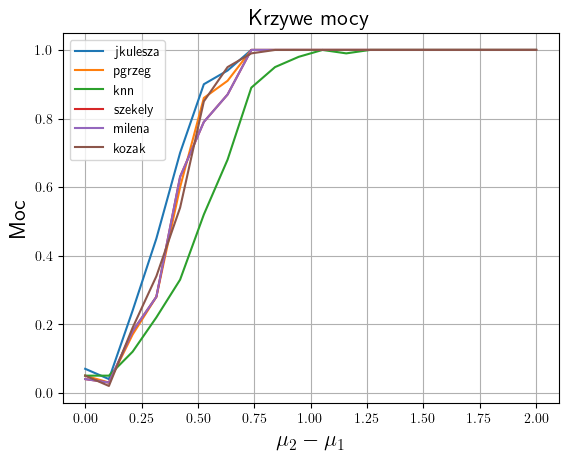

In [87]:
differences = np.linspace(0, 2, 20)  
calculate_multiple_powers(5, 0.4, 1.5, 2.5, differences, sample_size=15, num_tests=100, num_permutations=100, return_power=False)

Wcześniejsze wyliczenia, przed ostatnią implementacją

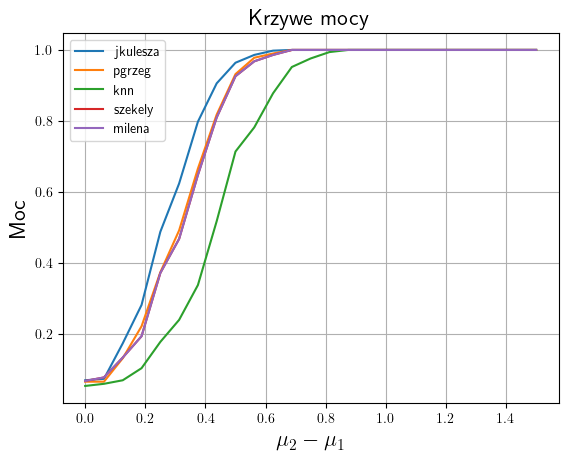

In [122]:
differences = np.linspace(0, 1.5, 25)  
df_TFN, df_Pgrzeg, df_KNN, df_szekely, df_milena = calculate_multiple_powers(5, 0.4, 1.5, 2.5, differences, sample_size=25, num_tests=500, num_permutations=500, return_power=True)

Do wywołania

In [ ]:
differences = np.linspace(0, 1.5, 20)  
df_TFN, df_Pgrzeg, df_KNN, df_szekely, df_milena, df_kozak = calculate_multiple_powers(5, 0.4, 1.5, 2.5, differences, sample_size=20, num_tests=400, num_permutations=400, return_power=False)

In [123]:
df_TFN.to_csv('power_data_jkulesza.csv', index=False)
df_Pgrzeg.to_csv('power_data_pgrzeg.csv', index=False)
df_KNN.to_csv('power_data_knn.csv', index=False)
df_szekely.to_csv('power_data_szekely.csv', index=False)
df_milena.to_csv('power_data_milena.csv', index=False)
df_kozak.to_csv('power_data_kozak.csv', index=False)